In [3]:
!pip install opendatasets

In [4]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/tapakah68/supervisely-filtered-segmentation-person-dataset")

Skipping, found downloaded files in "./supervisely-filtered-segmentation-person-dataset" (use force=True to force download)


In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [6]:
from torch.utils.data import Dataset
import os
from PIL import Image
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        #self.feature_extractor = feature_extractor
        self.train = train
        self.transforms = self.create_transforms()

        #sub_path = "training" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, "images")
        self.ann_dir = os.path.join(self.root_dir, "masks")

        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
          image_file_names.extend(files)
        self.images = sorted(image_file_names)

        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
          annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def create_transforms(self):
        _transforms = A.Compose([
            A.Resize(height=512, width=512),
            ToTensorV2(),
        ], p = 1,
        )
        return _transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = np.array(Image.open(os.path.join(self.img_dir, self.images[idx])).convert('RGB'))
        mask  = np.array(Image.open(os.path.join(self.ann_dir, self.annotations[idx])).convert('L'))
        if image.shape[-1] == 4:
            image = image[:, :, :4]
        encoded_inputs =  self.transforms(image = image, mask = mask)


        return encoded_inputs

In [7]:
from transformers import SegformerFeatureExtractor

root_dir = '/content/supervisely-filtered-segmentation-person-dataset/supervisely_person_clean_2667_img/supervisely_person_clean_2667_img'


train_dataset = SemanticSegmentationDataset(root_dir=root_dir)
valid_dataset = SemanticSegmentationDataset(root_dir=root_dir)

In [8]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 2667
Number of validation examples: 2667


In [9]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=2)

In [10]:
from transformers import SegformerForSemanticSegmentation
id2label = {0: 'background',
            255: 'person'}
label2id = {'background' : 0,
            'person': 255}
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=2,
                                                         id2label=id2label,
                                                         label2id=label2id,)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
#!pip install datasets

In [12]:
from datasets import load_metric
metric = load_metric("mean_iou")

In [13]:
import numpy as np
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()
for epoch in range(1):
   print("Epoch:", epoch)
   for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values = batch["image"].to(device).float()
        labels = batch["mask"].to(device).long()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        loss.backward()
        optimizer.step()

        # evaluate
        with torch.no_grad():
          upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
          predicted = upsampled_logits.argmax(dim=1)

          # note that the metric expects predictions + labels as numpy arrays
          metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        # let's print loss and metrics every 100 batches
        if idx % 100 == 0:
          metrics = metric._compute(references = labels.cpu(),
                                    predictions = predicted.cpu(),
                                    num_labels=len(id2label),
                                   ignore_index=255,
                                   reduce_labels=False, # we've already reduced the labels before)
          )

          print("Loss:", loss.item())
          print("Mean_iou:", metrics["mean_iou"])

          print("Mean accuracy:", metrics["mean_accuracy"])


Epoch: 0


  0%|          | 0/1334 [00:00<?, ?it/s]

/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/927b58f57da3f4b6e385e47d8a4b3947ee3f7cfcdba9b9359eba2ada2ed6b951/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Loss: 0.7197958827018738
Mean_iou: 0.13001608317948601
Mean accuracy: 0.26003216635897203
Loss: 0.20596015453338623
Mean_iou: 0.4907748947530306
Mean accuracy: 0.9815497895060612
Loss: 0.07641202211380005
Mean_iou: 0.4999173866844428
Mean accuracy: 0.9998347733688856
Loss: 0.12984183430671692
Mean_iou: 0.4998755703027789
Mean accuracy: 0.9997511406055578


/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/927b58f57da3f4b6e385e47d8a4b3947ee3f7cfcdba9b9359eba2ada2ed6b951/mean_iou.py:258: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union


Loss: 0.013587606139481068
Mean_iou: 1.0
Mean accuracy: 1.0
Loss: 0.05785350129008293
Mean_iou: 0.4934502610419955
Mean accuracy: 0.986900522083991
Loss: 0.006340894848108292
Mean_iou: 1.0
Mean accuracy: 1.0
Loss: 0.005683331284672022
Mean_iou: 1.0
Mean accuracy: 1.0
Loss: 0.0058012111112475395
Mean_iou: 1.0
Mean accuracy: 1.0
Loss: 0.007665000390261412
Mean_iou: 0.4999985805132864
Mean accuracy: 0.9999971610265728
Loss: 0.005586783867329359
Mean_iou: 0.49995072327285073
Mean accuracy: 0.9999014465457015
Loss: 0.009401495568454266
Mean_iou: 1.0
Mean accuracy: 1.0
Loss: 0.0033751914743334055
Mean_iou: 0.49997709594964773
Mean accuracy: 0.9999541918992955
Loss: 0.005569833796471357
Mean_iou: 1.0
Mean accuracy: 1.0


In [14]:
import os
os.makedirs('segformer_0_epoch/', exist_ok = True)
model.save_pretrained(save_directory = 'segformer_0_epoch/')

In [17]:
model = SegformerForSemanticSegmentation.from_pretrained('/content/segformer_0_epoch/')

In [19]:
image = Image.open('/content/supervisely-filtered-segmentation-person-dataset/supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/images/ds10_pexels-photo-687782.png')

In [20]:
# Transforms
_transform = A.Compose([
    A.Resize(height = 512, width=512),
    ToTensorV2(),
])

In [21]:
trans_image = _transform(image=np.array(image))

In [22]:
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 2, 128, 128])


In [23]:
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(logits,
                size=image.size[::-1], # (height, width)
                mode='bilinear',
                align_corners=False)

In [24]:
seg = upsampled_logits.argmax(dim=1)[0]
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array([[0, 0, 0],[255, 255, 255]])
for label, color in enumerate(palette):
    color_seg[seg == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

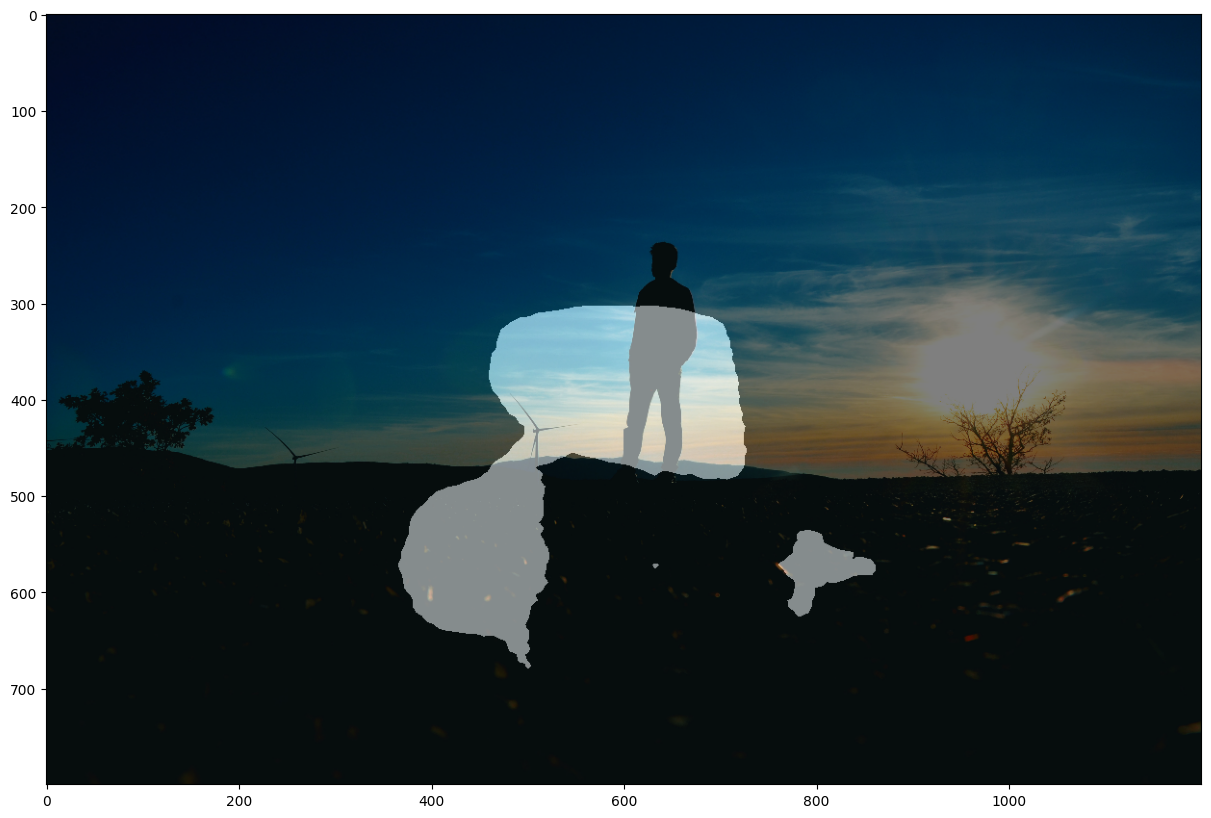

In [25]:
# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()